# Прогнозирование потребления электроэнергии в городе

В наличии были реальные данные потребляемой мощности в городе Выборг за 2018 год, значения фиксировались каждые полчаса и датасет состоял из 19000 строк. Известно, что потребляемая мощность хорошо коррелирует с метеорологическими и сезонными факторами, поэтому предварительно был догружен архив погоды за 2018 год и добавлен к датасету. <br>

Прошу учесть, что **это сырой проект**, в нем могут быть ошибки. Все предварительные исследования о влиянии различных факторов на потребляемую мощность и подбор оптимального периода предыстории для тренировочной выборки были проведены еще в 2021 году в моем дипломном проекте. Поэтому используются уже готовые эвристики. <br>

Здесь я просто пробую различные методы, которые дают хороший результат на нестационарных промежутках временного ряда (осенью, зимой, весной) — самые сложные периоды для прогнозирования, которые мне раньше не поддавались.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, SimpleRNN, InputLayer
from keras.layers import Activation, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

tf.config.set_visible_devices([], 'GPU') 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_percentage_error as mape, 
    r2_score as r2,
    mean_absolute_error as mae, 
    mean_squared_error as mse
)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 200)

In [4]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import os
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    import random
    random.seed(seed)

set_seed(1)

In [5]:
plt.rc('lines', linewidth=1)
plt.rcParams.update({'font.size': 7})

## Подготовка данных

Для прогнозов нужно вытащить максимум информации из двух столбцов: дата и потребляемая мощность. Поскольку процесс носит цикличный характер и менятся в течение суток, недели и года, были созданы соответствующие фичи. 
Также хороший прирост в точности дала разница температуры за час (2 наблюдения) — `T_diff`.

In [6]:
def edit(data):
    data = data.drop([5016, 5715, 5476, 5478, 1170, 1171, 1172], axis=0) #выбросы
    data.index = data['date']
    
    data = data[pd.DatetimeIndex(data.index).year == 2018] #за 2019 год мало наблюдений
    #data['season'] = data['season'].astype('category')
    #data['hours'] = pd.DatetimeIndex(data.index).hour + (pd.DatetimeIndex(data.index).minute / 60)
    data['days'] = pd.DatetimeIndex(data.index).weekday
    data['weekend'] = pd.DatetimeIndex(data.index).weekday.isin([5,6])*1
    #data['month'] = pd.DatetimeIndex(data.index).month
    data['weekofyear'] = data.index.isocalendar().week
    #data['dayofyear'] = data.index.isocalendar().day
    
    data['T_diff'] = data['T'] - data['T'].shift(2)
    
    data.drop(['time_num', 'date'], axis=1, inplace=True)
    data = data[data['P'] > 400] #исключим выбросы

    #data = pd.get_dummies(data, columns=['season'])
    return data

In [7]:
def code_mean(data, category_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака category_feature,
    а значениями - средние по real_feature
    """
    return dict(data.groupby(category_feature)[real_feature].mean())

In [8]:
def prepareData(data, lag_start=48, lag_end=48*7, test_size=0.2): #48 наблюдений в одних сутках на 7 дней недели
    data['P'] = data['P'] / 100 #масштабируем
    data['P_diff'] = data['P'] - data['P'].shift(1)
    test_index = int(len(data)*(1-test_size))
        
    data['week_mean'] = list(map(code_mean(data[:test_index], 'weekofyear', 'P').get, data.weekofyear))
    data['hours'] = pd.DatetimeIndex(data.index).hour + (pd.DatetimeIndex(data.index).minute / 60) #час + 0,5часа(30 минут)
    data['lag_week'] = data['week_mean'].shift(lag_end) #лаг недели
    data['timestamp'] = data.index
    
    data['moving_average'] = data['P'].rolling( #очень поможет в прогнозах
        window=48,       # 1-day window
        center=True,     # puts the average at the center of the window
        min_periods=24,  # choose about half the window size
    ).mean()             # compute the mean (could also do median, std, min, max, ...)
    
    data = data.reset_index(drop=True)
    
    columns = ['P', 'hours', 'days', 'T', 'weekend', 'lag_week', 'moving_average', 'T_diff', 'timestamp']
    x_train, x_test, y_train, y_test = train_test_split(data[columns].drop(['P'], axis=1), 
                                                        data['P'], test_size=0.2, 
                                                        random_state=42, shuffle=False).copy() #обязательно shuffle=False
    for item in [x_train, x_test, y_train, y_test]:
        item.reset_index(drop=True, inplace=True)
    
    #print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    return x_train, y_train, x_test, y_test

In [9]:
def scores(y_true, y_pred):
    print('MAPE =', format(mape(y_true, y_pred) * 100, '.2f'))
    print('r2 =', format(r2(y_true, y_pred), '.3f'))
    print('MAE =', format(mae(y_true, y_pred), '.3f'))
    print('MSE =', format(mse(y_true, y_pred), '.3f'))
    print('RMSE = ', format(np.sqrt(mse(y_true, y_pred)), '.3f'))
    return None

In [10]:
dataset = pd.read_excel('datasets/power.xlsx', sheet_name=0)
dataset = edit(dataset)

In [11]:
dataset.head()

,P,hours,days,T,Po,Pa,U,Ff,N,H,VV,Td,season,weekend,weekofyear,T_diff
date,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1209.6,3.0,0,-0.400000,752.50,-1.20,87.000000,4,90,3000,10.0,-2.4,winter,0,1,NaN
2018-01-01 00:30:00,1200.8,3.5,0,-0.433333,752.25,-1.25,87.166667,4,90,3000,10.0,-2.4,winter,0,1,NaN
2018-01-01 01:00:00,1191.6,4.0,0,-0.466667,752.00,-1.30,87.333333,4,90,3000,10.0,-2.4,winter,0,1,-0.066667
2018-01-01 01:30:00,1188.4,4.5,0,-0.500000,751.75,-1.35,87.500000,4,90,3000,10.0,-2.4,winter,0,1,-0.066667
2018-01-01 02:00:00,1155.6,5.0,0,-0.533333,751.50,-1.40,87.666667,4,90,3000,10.0,-2.4,winter,0,1,-0.066667


### Годовой график потребляемой мощности

Как видим, ряд нестационарный: от зимы к лету мощность постепенно снижается, к зиме — повышается. Летом ряд примерно постоянный, и поэтому там получаются самые точные прогнозы (mape 4-5%). Задача будет состоять в недельном прогнозировании по истории в 5 недель. Были выделены соответствующие сезонные периоды, чтобы проверять адекватность методов во все времена года.

In [12]:
winter = np.arange(300,3500)
spring = np.arange(3000,6500)
summer = np.arange(6000,9500)
autumn = np.arange(9500,13000)

In [13]:
data = dataset.iloc[autumn].copy()

In [14]:
x_train, y_train, x_test, y_test = prepareData(data)

In [15]:
n_week = 48*7
x_train, y_train = x_train[-5*n_week:], y_train[-5*n_week:] #5 недель в трейн
x_test, y_test = x_test[:n_week], y_test[:n_week] #1 неделя в тест

for item in [x_train, x_test, y_train, y_test]:
        item.reset_index(drop=True, inplace=True)

In [16]:
x_test.isna().sum()

hours             0
days              0
T                 0
weekend           0
lag_week          0
moving_average    0
T_diff            0
timestamp         0
dtype: int64

Раннее было замечено, что наличие скользящего среднего очень сильно повышает гибкость методов, поскольку не все они могут аппроксимировать значения за пределы обучающей выборки, а это неизбежно ввиду нестационарности ряда. <br>

Идея заключается в следующем: спрогнозируем в тестовую выборку скользящее среднее и будем использовать как фичу в окончательных прогнозах. <br>
**Тут возникает проблема в ограниченности данных для такого прогноза: мы не можем использовать лаги по дням, среднее дня и т.п. — данные из будущего. Доступен только лаг на неделю и вариации температурных показателей.**

In [17]:
#для окончательного прогноза
x_train = x_train.loc[:,['hours', 'days', 'weekend', 'T', 'lag_week', 'moving_average', 'T_diff', 'timestamp']]
x_test = x_test.loc[:,['hours', 'days', 'weekend', 'T', 'lag_week', 'moving_average', 'T_diff', 'timestamp']]

In [18]:
x_train.head()

,hours,days,weekend,T,lag_week,moving_average,T_diff,timestamp
0,5.5,6,1,16.550000,6.581685,6.817583,0.100000,2018-08-12 05:30:00
1,6.0,6,1,16.600000,6.581685,6.840500,0.100000,2018-08-12 06:00:00
2,6.5,6,1,17.016667,6.581685,6.858250,0.466667,2018-08-12 06:30:00
3,7.0,6,1,17.433333,6.581685,6.867333,0.833333,2018-08-12 07:00:00
4,7.5,6,1,17.850000,6.581685,6.872083,0.833333,2018-08-12 07:30:00


In [19]:
#для скользящего среднего
moving_features = ['hours', 'days', 'weekend', 'T', 'lag_week', 'T_diff']

In [20]:
x_train_moving = x_train.loc[:, moving_features]
x_test_moving = x_test.loc[:, moving_features]

In [21]:
y_train_moving = y_train
y_test_moving = y_test

In [22]:
x_train_moving, x_val_moving, y_train_moving, y_val_moving = train_test_split(x_train_moving, y_train_moving, test_size=0.2, 
                                                                      random_state=42, shuffle=False).copy()

In [23]:
x_train_moving.head()

,hours,days,weekend,T,lag_week,T_diff
0,5.5,6,1,16.550000,6.581685,0.100000
1,6.0,6,1,16.600000,6.581685,0.100000
2,6.5,6,1,17.016667,6.581685,0.466667
3,7.0,6,1,17.433333,6.581685,0.833333
4,7.5,6,1,17.850000,6.581685,0.833333


In [24]:
y_train_moving.head()

0    5.828
1    6.332
2    6.724
3    6.912
4    7.436
Name: P, dtype: float64

## Прогнозирование скользящего среднего

По сути это было самой сложной задачей: по минимуму доступных данных хотя бы грубо научиться предсказывать тренд. Случайный лес и градиентный бустинг не подошли, потому что деревья не аппроксимируют зависимость. Более-менее нормальные прогнозы дала *рекурентная нейронная сеть с долгой краткосрочной памятью LSTM*, но не во всех сезонах она работала хорошо. Поэтому также была добавлена *линейная регрессия Надарая Ватсона*, которая заменяла нейронную сеть в случае плохих результатов. <br>

Выбор наилучшей модели проводился на заранее отложенной валидационной выборке.

In [25]:
def fit_moving(model):
    set_seed(31415)
    best_score = -1
    best_pred = []
    best_model = []
    for i in range(1,7): #30 эпох 16 батчей имба (мб 24/48 батчей), без эрли стоп, лр=0.01
        history = model.fit(x_train_moving, y_train_moving, epochs=30, batch_size=16,validation_split=0.2)#callbacks=[early_stopping])
        pred = pd.Series(model.predict(x_val_moving).ravel())
        print('****************R2_val = ', r2(y_val_moving, pred))
        if r2(y_val_moving, pred) > best_score: #y_val будет доступен на тот момент, можем ориентироваться на него
            best_score = r2(y_val_moving, pred)
            best_pred = pred
            best_model = model
    return best_pred, best_model, history

### CNN

In [27]:
set_seed(1)
opt = keras.optimizers.legacy.Adam(learning_rate=0.005) #0.005 0.0075 0.01 – имба

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (2, 8) * 1:
    model.add(keras.layers.Conv1D(filters=10, kernel_size=2, padding="causal", activation="relu", dilation_rate=rate))
model.add(LSTM(units=40, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1))
model.compile(loss="mse", optimizer=opt)
#history = model.fit(x_train_moving, y_train_moving, epochs=20, validation_split=0.2)

In [28]:
%%time
set_seed(1)

conv_best_pred_moving, bets_conv, conv_history = fit_moving(model)

Epoch 1/30


2023-06-04 14:49:13.065984: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


68/68 [==============================] - 1s 3ms/step - loss: 7.8079 - val_loss: 3.6200
Epoch 2/30
68/68 [==============================] - 0s 1ms/step - loss: 0.9005 - val_loss: 3.1676
Epoch 3/30
68/68 [==============================] - 0s 1ms/step - loss: 0.7973 - val_loss: 2.8671
Epoch 4/30
68/68 [==============================] - 0s 1ms/step - loss: 0.7189 - val_loss: 3.6090
Epoch 5/30
68/68 [==============================] - 0s 1ms/step - loss: 0.7314 - val_loss: 2.5498
Epoch 6/30
68/68 [==============================] - 0s 1ms/step - loss: 0.7185 - val_loss: 2.6356
Epoch 7/30
68/68 [==============================] - 0s 1ms/step - loss: 0.7513 - val_loss: 3.6071
Epoch 8/30
68/68 [==============================] - 0s 1ms/step - loss: 0.7376 - val_loss: 3.4170
Epoch 9/30
68/68 [==============================] - 0s 1ms/step - loss: 0.6536 - val_loss: 3.2335
Epoch 10/30
68/68 [==============================] - 0s 1ms/step - loss: 0.6314 - val_loss: 2.2842
Epoch 11/30
68/68 [===========

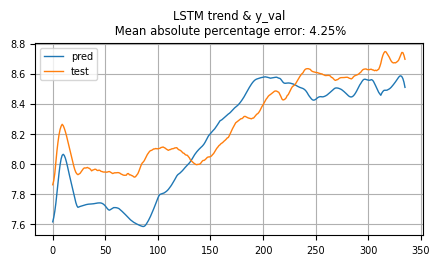

In [29]:
plt.figure(figsize=(5,2.5))
plt.plot(conv_best_pred_moving.rolling(
        window=48,       # 1-day window
        center=True,     # puts the average at the center of the window
        min_periods=6  # choose about half the window size
        ).mean(), label='pred')
plt.plot(pd.Series(y_val_moving.values).rolling(
        window=48,       # 1-day window
        center=True,     # puts the average at the center of the window
        min_periods=6  # choose about half the window size
        ).mean(), label='test')
plt.legend(loc='best')
plt.title(f'LSTM trend & y_val\n Mean absolute percentage error: {mape(y_val_moving, conv_best_pred_moving):.2%}')
plt.grid(True)

### LSTM

In [30]:
def fit_moving(model):
    set_seed(31415)
    best_score = -1
    for i in range(1,7): #30 эпох 16 батчей имба (мб 24/48 батчей), без эрли стоп, лр=0.01
        #history = model.fit(pd.concat([x_train_moving, x_val_moving], axis=0), 
        #                    pd.concat([y_train_moving, y_val_moving], axis=0), 
        #                    epochs=30, batch_size=16, validation_split=0.2)
        history = model.fit(x_train_moving, y_train_moving, epochs=30, batch_size=16, validation_split=0.2)
        pred = pd.Series(model.predict(x_val_moving).ravel())
        print('****************R2_val = ', r2(y_val_moving, pred))
        if r2(y_val_moving, pred) > best_score: #y_val будет доступен на тот момент, можем ориентироваться на него
            best_score = r2(y_val_moving, pred)
            best_pred = pred
            best_model = model.save('models/my_model.h5') 
    best_model = tf.keras.models.load_model('models/my_model.h5')
    best_model.evaluate(x_train_moving, y_train_moving)
    
    return best_pred, best_model, history

In [31]:
set_seed(1)
rnn = Sequential()
rnn.add(InputLayer(input_shape=[None,1]))

rnn.add(BatchNormalization())
rnn.add(LSTM(units=40, activation='relu'))
rnn.add(Dropout(0.05))

rnn.add(BatchNormalization())
rnn.add(Dense(40, activation='relu'))
rnn.add(Dropout(0.05))
rnn.add(BatchNormalization())
rnn.add(Dense(1))

opt = keras.optimizers.legacy.Adam(learning_rate=0.005) #0.005 0.0075 0.01 – имба
rnn.compile(loss='mse', optimizer=opt)#, metrics=r2_keras)

In [32]:
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, None, 1)          4         
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 40)                6720      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 40)               160       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 40)                1640      
                                                                 
 dropout_1 (Dropout)         (None, 40)               

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6, min_delta=0.0015)

Тут спорный момент, но несколько итераций с меньшим числом эпох давало результаты лучше, иначе `early_stop` не позволял дообучить модель.

In [34]:
%%time
set_seed(1)
best_pred_moving, best_rnn, history = fit_moving(rnn)

Epoch 1/30
68/68 [==============================] - 1s 2ms/step - loss: 28.7189 - val_loss: 7.5744
Epoch 2/30
68/68 [==============================] - 0s 1ms/step - loss: 1.5080 - val_loss: 2.5181
Epoch 3/30
68/68 [==============================] - 0s 1ms/step - loss: 1.1280 - val_loss: 4.9069
Epoch 4/30
68/68 [==============================] - 0s 1ms/step - loss: 1.0183 - val_loss: 5.4058
Epoch 5/30
68/68 [==============================] - 0s 1ms/step - loss: 0.9351 - val_loss: 3.6185
Epoch 6/30
68/68 [==============================] - 0s 1ms/step - loss: 0.7976 - val_loss: 3.5022
Epoch 7/30
68/68 [==============================] - 0s 1ms/step - loss: 0.7803 - val_loss: 2.6823
Epoch 8/30
68/68 [==============================] - 0s 1ms/step - loss: 0.7582 - val_loss: 3.5782
Epoch 9/30
68/68 [==============================] - 0s 1ms/step - loss: 0.7190 - val_loss: 5.7810
Epoch 10/30
68/68 [==============================] - 0s 1ms/step - loss: 0.7019 - val_loss: 3.2536
Epoch 11/30
68/68 

In [35]:
best_pred_moving.head()

0    7.797234
1    7.951540
2    8.094215
3    8.200291
4    8.283412
dtype: float32

In [36]:
pd.Series(best_rnn.predict(x_val_moving).ravel()).head()

11/11 [==============================] - 0s 661us/step


0    7.797234
1    7.951540
2    8.094215
3    8.200291
4    8.283412
dtype: float32

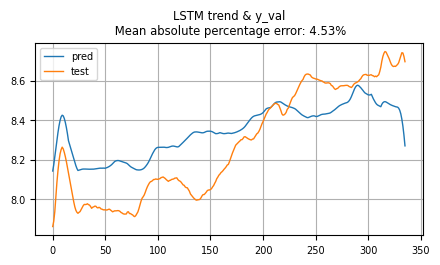

In [37]:
plt.figure(figsize=(5,2.5))
plt.plot(best_pred_moving.rolling(
        window=48,       # 1-day window
        center=True,     # puts the average at the center of the window
        min_periods=6  # choose about half the window size
        ).mean(), label='pred')
plt.plot(pd.Series(y_val_moving.values).rolling(
        window=48,       # 1-day window
        center=True,     # puts the average at the center of the window
        min_periods=6  # choose about half the window size
        ).mean(), label='test')
plt.legend(loc='best')
plt.title(f'LSTM trend & y_val\n Mean absolute percentage error: {mape(y_val_moving, best_pred_moving):.2%}')
plt.grid(True)

11/11 [==============================] - 0s 671us/step


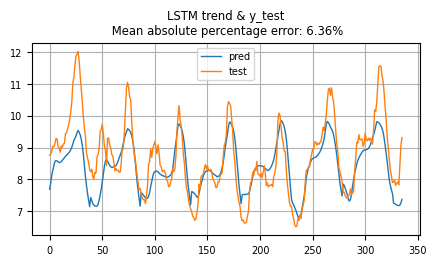

In [38]:
#plt.rcParams['font.size'] = '7'
plt.figure(figsize=(5,2.5))
plt.plot(best_rnn.predict(x_test[moving_features]), label='pred')
plt.plot(pd.Series(y_test_moving.values), label='test')
plt.legend(loc='best')
plt.title(f'LSTM trend & y_test\n Mean absolute percentage error: {mape(y_test_moving, best_rnn.predict(x_test[moving_features])):.2%}')
plt.grid(True)

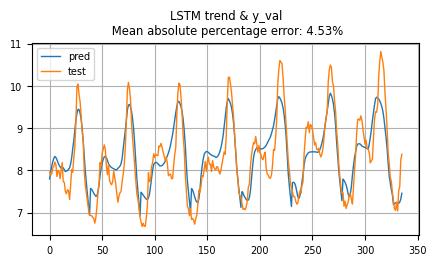

In [39]:
#plt.rcParams['font.size'] = '7'
plt.figure(figsize=(5,2.5))
plt.plot(best_pred_moving, label='pred')
plt.plot(pd.Series(y_val_moving.values), label='test')
plt.legend(loc='best')
plt.title(f'LSTM trend & y_val\n Mean absolute percentage error: {mape(y_val_moving, best_pred_moving):.2%}')
plt.grid(True)

По сути мы уже получили готовые прогнозы для мощности, иногда они уже бывают приемлемыми, но так выходит не всегда. Особенно на тесте. Если же воспользоваться ими и дообучить модели, как правило, получаются более точные результаты.

In [40]:
scores(y_val_moving, best_pred_moving)

MAPE = 4.53
r2 = 0.763
MAE = 0.374
MSE = 0.205
RMSE =  0.453


In [41]:
scores(y_test, best_rnn.predict(x_test[moving_features]))

11/11 [==============================] - 0s 803us/step
MAPE = 6.36
r2 = 0.558
MAE = 0.575
MSE = 0.578
RMSE =  0.760


### Линейная модель: регрессия Надарая-Ватсона

In [42]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, KFold

tscv = TimeSeriesSplit(n_splits=3)
kf = KFold(n_splits=3, shuffle=False)
krr = KernelRidge()

param_grid = {'alpha': [10, 100, 200, 500], 'degree': list(range(2,4)), 'kernel': ['polynomial', 'linear']}
grid = GridSearchCV(krr, param_grid=param_grid, cv=kf, verbose=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [43]:
grid.fit(x_train_moving, y_train_moving)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=KernelRidge(), n_jobs=-1,
             param_grid={'alpha': [10, 100, 200, 500], 'degree': [2, 3],
                         'kernel': ['polynomial', 'linear']},
             scoring='neg_mean_squared_error', verbose=3)

In [44]:
#print('MSE =', -grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

{'alpha': 100, 'degree': 2, 'kernel': 'polynomial'}
KernelRidge(alpha=100, degree=2, kernel='polynomial')


In [45]:
krr = grid.best_estimator_

In [46]:
krr.fit(x_train_moving, y_train_moving) #обучаем на всем датасете
lr_best_pred_moving = pd.Series(krr.predict(x_val_moving))

In [47]:
#krr = KernelRidge(alpha=500, kernel='polynomial', degree=3)
#krr.fit(x_train_moving, y_train_moving)
#lr_best_pred_moving = pd.Series(krr.predict(x_val_moving))

In [48]:
scores(y_val_moving, lr_best_pred_moving)

MAPE = 7.54
r2 = 0.261
MAE = 0.634
MSE = 0.640
RMSE =  0.800


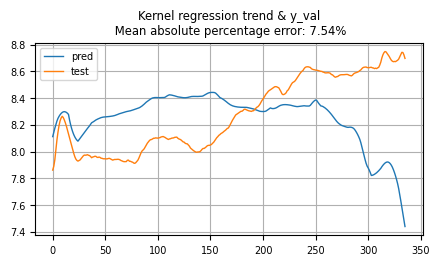

In [49]:
plt.figure(figsize=(5,2.5))
plt.plot(lr_best_pred_moving.rolling(
        window=48,       # 1-day window
        center=True,     # puts the average at the center of the window
        min_periods=6  # choose about half the window size
        ).mean(), label='pred')
plt.plot(pd.Series(y_val_moving.values).rolling(
        window=48,       # 1-day window
        center=True,     # puts the average at the center of the window
        min_periods=6  # choose about half the window size
        ).mean(), label='test')
plt.legend(loc='best')
plt.title(f'Kernel regression trend & y_val\n Mean absolute percentage error: {mape(y_val_moving, lr_best_pred_moving):.2%}')
plt.grid(True)

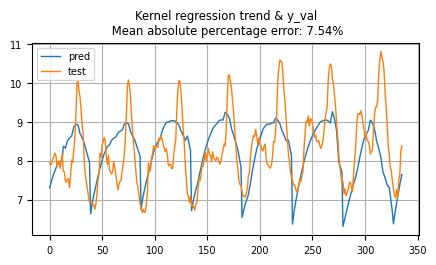

In [50]:
plt.figure(figsize=(5,2.5))
plt.plot(lr_best_pred_moving, label='pred')
plt.plot(y_val_moving.values, label='test')
plt.legend(loc='best')
plt.title(f'Kernel regression trend & y_val\n Mean absolute percentage error: {mape(y_val_moving, lr_best_pred_moving):.2%}')
plt.grid(True)

#### Выбор модели для прогнозирования фичи `moving_average`

In [51]:
scores(y_val_moving, rnn.predict(x_val_moving)) #LSTM val

11/11 [==============================] - 0s 634us/step
MAPE = 5.36
r2 = 0.660
MAE = 0.439
MSE = 0.295
RMSE =  0.543


In [52]:
scores(y_val_moving, krr.predict(x_val_moving)) #Kernel val

MAPE = 7.54
r2 = 0.261
MAE = 0.634
MSE = 0.640
RMSE =  0.800


In [53]:
def best_moving(krr, rnn):
    if r2(y_val_moving, rnn.predict(x_val_moving)) > r2(y_val_moving, krr.predict(x_val_moving)):
        return pd.Series(rnn.predict(x_test_moving).ravel())
    return pd.Series(krr.predict(x_test_moving))

Добавляем `'moving_average'` в тест:

In [54]:
x_test['moving_average'] = best_moving(krr, rnn).rolling(
    window=48, 
    center=True, 
    min_periods=6
).mean().copy()

11/11 [==============================] - 0s 2ms/step


### Окончательное прогнозирование потребляемой мощности

In [55]:
features = ['hours', 'days', 'weekend', 'T', 'lag_week', 'moving_average', 'T_diff']

In [56]:
set_seed(1)
rnn2 = Sequential()
rnn2.add(InputLayer(input_shape=[None,1]))

#rnn2.add(BatchNormalization())
rnn2.add(LSTM(units=36, activation='leaky_relu'))
#rnn2.add(Dropout(0.02))

#rnn2.add(BatchNormalization())
rnn2.add(Dense(36, activation='leaky_relu'))

#rnn2.add(Dropout(0.02))
#rnn2.add(BatchNormalization())
rnn2.add(Dense(1))

opt = keras.optimizers.legacy.Adam(learning_rate=0.005) #0.005 0.0075 0.01 – имба
rnn2.compile(loss='mse', optimizer=opt)#, metrics=r2_keras)

In [57]:
set_seed(1)
rnn1 = Sequential()
rnn1.add(LSTM(units=32, input_shape=[None, 1], activation='leaky_relu'))
rnn1.add(Dense(32, activation='leaky_relu'))
rnn1.add(Dense(1))

opt = keras.optimizers.legacy.Adam(learning_rate=0.005)
rnn1.compile(loss='mse', optimizer=opt)

In [58]:
early_stopping_p = EarlyStopping(monitor='val_loss', patience=24, min_delta=0.0015)

In [59]:
def fit_p(model):
    set_seed(1)
    for i in range(1,4):
        model.fit(x_train[features], y_train, epochs=24, batch_size=8, validation_split=0)#, callbacks=[early_stopping_p])
        pred = model.predict(x_test[features])
        print('****************R2_test = ', r2(y_test, pred))

    return pred

In [60]:
best_pred = fit_p(rnn1)

Epoch 1/24
210/210 [==============================] - 0s 667us/step - loss: 3.3138
Epoch 2/24
210/210 [==============================] - 0s 655us/step - loss: 0.7633
Epoch 3/24
210/210 [==============================] - 0s 650us/step - loss: 0.7263
Epoch 4/24
210/210 [==============================] - 0s 644us/step - loss: 0.7493
Epoch 5/24
210/210 [==============================] - 0s 690us/step - loss: 0.6677
Epoch 6/24
210/210 [==============================] - 0s 659us/step - loss: 0.6580
Epoch 7/24
210/210 [==============================] - 0s 653us/step - loss: 0.5908
Epoch 8/24
210/210 [==============================] - 0s 652us/step - loss: 0.5171
Epoch 9/24
210/210 [==============================] - 0s 642us/step - loss: 0.4464
Epoch 10/24
210/210 [==============================] - 0s 649us/step - loss: 0.4063
Epoch 11/24
210/210 [==============================] - 0s 702us/step - loss: 0.3465
Epoch 12/24
210/210 [==============================] - 0s 654us/step - loss: 0.3065
E

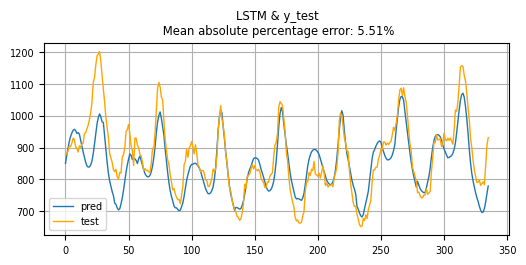

In [61]:
plt.figure(figsize=(6,2.5))
plt.plot(best_pred*100, label='pred',linewidth=1) 
plt.plot(y_test*100, color='orange', label='test',linewidth=1)
plt.legend(loc='best')
plt.title(f'LSTM & y_test\n Mean absolute percentage error: {mape(y_test, best_pred):.2%}')
plt.grid(True)

In [62]:
scores(y_test*100, best_pred*100) #домножаем на 100, чтобы вернуть масштаб

MAPE = 5.51
r2 = 0.688
MAE = 49.052
MSE = 4072.542
RMSE =  63.816


## Случайный лес

In [63]:
from sklearn.ensemble import RandomForestRegressor
set_seed(1)
rf = RandomForestRegressor(n_estimators=100, max_depth=12)
rf.fit(x_train[features], y_train)
rf_pred = rf.predict(x_test[features])

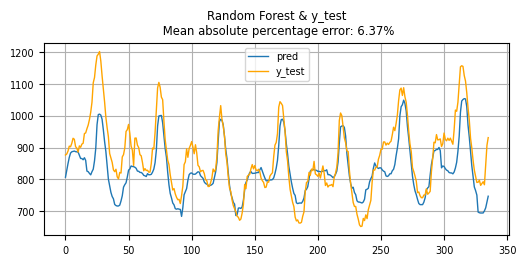

In [64]:
plt.figure(figsize=(6,2.5))
plt.plot(rf_pred*100, label='pred')
plt.plot(y_test.values*100, color='orange', label='y_test')
plt.legend(loc='best')
plt.title(f'Random Forest & y_test\n Mean absolute percentage error: {mape(y_test, rf_pred):.2%}')
plt.grid(True)

In [65]:
scores(y_test*100, rf_pred*100)

MAPE = 6.37
r2 = 0.560
MAE = 57.446
MSE = 5743.641
RMSE =  75.787


## Градиентный бустинг

In [66]:
from catboost import CatBoostRegressor
set_seed(1)
#features = ['hours', 'days', 'weekend', 'T', 'lag_week', 'moving_average', 'T_diff']    

cat = CatBoostRegressor(iterations=100, learning_rate=0.071, loss_function='RMSE')
cat.fit(x_train[features], y_train, cat_features=['days', 'weekend'], verbose=False, plot=False)
cat_pred = cat.predict(x_test[features])

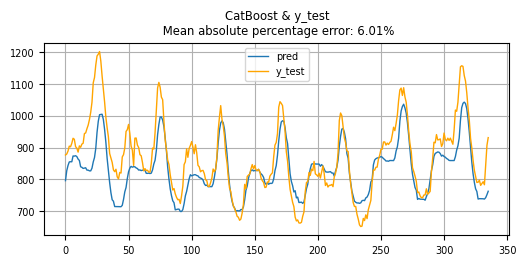

In [67]:
plt.figure(figsize=(6,2.5))
plt.plot(cat_pred*100, label='pred')
plt.plot(y_test.values*100, color='orange', label='y_test')
plt.legend(loc='best')
plt.title(f'CatBoost & y_test\n Mean absolute percentage error: {mape(y_test, cat_pred):.2%}')
plt.grid(True)

In [68]:
scores(y_test*100, cat_pred*100)

MAPE = 6.01
r2 = 0.596
MAE = 54.478
MSE = 5275.311
RMSE =  72.631


Здесь лучший результат показала LSTM но, как правило, именно градиентный бустинг дает наименьшую ошибку: вне зависимости от выбора между kernel и LSTM при прогнозировании `moving_average`.

Также удобно судить об адекватности прогноза нейронной сети по виду кривой: нижний пик никогда не будет равен или выше верхнего, к тому же, всегда можно сравнить с видом вчерашней кривой или видом прогнозов бустинга/случайного леса. Если они плохо совпадают, имеет смысл обучить нейронную сеть заново.